In [15]:
import os
import pandas as pd
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from scipy.signal import savgol_filter
import numpy as np
import scipy.stats as stats
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import Counter


In [2]:
def read_and_label_files(directory, activity_prefix):
    data_list = []
    for filename in os.listdir(directory):
        if filename.startswith(activity_prefix) and filename.endswith('.csv'):
            file_path = os.path.join(directory, filename)
            data = pd.read_csv(file_path)
            data = smooth_data(data)  # Applying smoothing filter
            data['activity'] = activity_prefix  # Using the activity prefix as the label
            data_list.append(data) 
    return pd.concat(data_list, ignore_index=True)

def smooth_data(data):
    for column in ['x', 'y', 'z']:
        data[column] = savgol_filter(data[column], window_length=5, polyorder=3)
    return data

def segment_into_windows(data, points_per_window):
    windows = []
    for start in range(0, len(data), points_per_window):
        end = start + points_per_window
        # Discarding the last window if it has fewer points than `points_per_window`
        if end <= len(data):
            window = data.iloc[start:end]
            windows.append(window)
    return windows

#Combining files after labeling
walking_data = read_and_label_files('/Users/Pradeep/Desktop/aalll CS655/MLHAR/my_files/Walking', 'walking') #acc
sitting_data = read_and_label_files('/Users/Pradeep/Desktop/aalll CS655/MLHAR/my_files/Sitting', 'sitting') #acc
running_data = read_and_label_files('/Users/Pradeep/Desktop/aalll CS655/MLHAR/my_files/Running', 'running') #acc
rotating_data = read_and_label_files('/Users/Pradeep/Desktop/aalll CS655/MLHAR/my_files/Rotating', 'rotating') #gyro
standing_data = read_and_label_files('/Users/Pradeep/Desktop/aalll CS655/MLHAR/my_files/Standing', 'standing') #acc
liftUp_data = read_and_label_files('/Users/Pradeep/Desktop/aalll CS655/MLHAR/my_files/ElevatorUp', 'liftUp') #gravity
liftDown_data = read_and_label_files('/Users/Pradeep/Desktop/aalll CS655/MLHAR/my_files/ElevatorDown', 'liftDown') #gravity
stairUp_data = read_and_label_files('/Users/Pradeep/Desktop/aalll CS655/MLHAR/my_files/StairUp/gravity', 'stairUp') #gravity
stairDown_data = read_and_label_files('/Users/Pradeep/Desktop/aalll CS655/MLHAR/my_files/StairDown/gravity', 'stairDown') #gravity
sweeping_data = read_and_label_files('/Users/Pradeep/Desktop/aalll CS655/MLHAR/my_files/Sweeping', 'sweeping') #acc
bodyrotating_data = read_and_label_files('/Users/Pradeep/Desktop/aalll CS655/MLHAR/my_files/BodyRotating', 'bodyrotating') #gyro
waving_data = read_and_label_files('/Users/Pradeep/Desktop/aalll CS655/MLHAR/my_files/Waving', 'waving') #acc
liftwt_data = read_and_label_files('/Users/Pradeep/Desktop/aalll CS655/MLHAR/my_files/liftingwt', 'liftwt') #gyro
yoga_data = read_and_label_files('/Users/Pradeep/Desktop/aalll CS655/MLHAR/my_files/yoga', 'yoga') #acc
typing_data = read_and_label_files('/Users/Pradeep/Desktop/aalll CS655/MLHAR/my_files/typing', 'typing') #gyro
drinking_data = read_and_label_files('/Users/Pradeep/Desktop/aalll CS655/MLHAR/my_files/drinking', 'drink') #gyro
balling_data = read_and_label_files('/Users/Pradeep/Desktop/aalll CS655/MLHAR/my_files/balling', 'ball') #gyro


# Combine all data 
all_data = pd.concat([walking_data, sitting_data,running_data,rotating_data,standing_data,liftUp_data, liftDown_data, sweeping_data,stairUp_data,stairDown_data, bodyrotating_data,liftwt_data,waving_data, yoga_data, typing_data, drinking_data, balling_data], ignore_index=True)
all_data.shape

# Segmenting into windows
points_per_window = 58 * 2  # 58 Hz * 2 seconds(copped window)
windows = segment_into_windows(all_data, points_per_window)
# Now, `windows` is a list where each element is a DataFrame representing a 2-second window

print(f"Number of windows: {len(windows)}")
print(f"Number of Data's (Rows, Col): {all_data.shape}")
activity_counts = all_data['activity'].value_counts()
print(activity_counts)


Number of windows: 5097
Number of Data's (Rows, Col): (591362, 6)
activity
walking         76444
standing        51381
liftUp          42966
liftDown        39879
stairUp         38096
stairDown       37357
waving          35095
sitting         33905
drink           31270
running         29915
rotating        28264
typing          27363
liftwt          26905
yoga            26220
bodyrotating    23023
sweeping        22126
ball            21153
Name: count, dtype: int64


In [3]:

def extract_features(window):
    features = {}
    
    if 'activity' in window.columns:
        features['activity'] = window['activity'].iloc[0]
    
    # Statistical features
    for axis in ['x', 'y', 'z']:
        data = window[axis]
        features[f'{axis}_mean'] = np.mean(data)
        features[f'{axis}_std'] = np.std(data)
        features[f'{axis}_var'] = np.var(data)
        features[f'{axis}_median'] = np.median(data)
        features[f'{axis}_skew'] = stats.skew(data)
        features[f'{axis}_kurtosis'] = stats.kurtosis(data)
    
    # Time-domain features
    for axis in ['x', 'y', 'z']:
        data = window[axis]
        features[f'{axis}_rms'] = np.sqrt(np.mean(data**2))
        features[f'{axis}_zero_crossing_rate'] = np.sum(np.diff(np.sign(data)) != 0) / len(data)
        features[f'{axis}_sma'] = np.sum(np.abs(data))
        features[f'{axis}_energy'] = np.sum(data**2)

        # Entropy (using histogram for probability distribution)
        hist, bin_edges = np.histogram(data, bins=10, density=True)
        hist = np.nan_to_num(hist, nan=0.0)  # Replace NaN with 0
        hist = hist / hist.sum()  # Normalize to create a probability distribution
        entropy = -np.sum(hist * np.log2(hist + 1e-9))  # Log of zero handled by adding a small value (1e-9)
        features[f'{axis}_entropy'] = entropy
    
    # Frequency-domain features (using FFT)
    for axis in ['x', 'y', 'z']:
        data = window[axis]
        fft_values = np.fft.fft(data)
        fft_values = np.abs(fft_values)
        dominant_frequency = np.argmax(fft_values)
        spectral_entropy = -np.sum((fft_values / np.sum(fft_values)) * np.log2(fft_values / np.sum(fft_values) + 1e-9))
        features[f'{axis}_dominant_frequency'] = dominant_frequency
        features[f'{axis}_spectral_entropy'] = spectral_entropy

    # SMA for the window
    features['sma'] = np.sum(np.abs(window['x']) + np.abs(window['y']) + np.abs(window['z']))
    
    # Autocorrelation features for each axis
    for axis in ['x', 'y', 'z']:
        data = window[axis]
        autocorr_features = np.correlate(data - np.mean(data), data - np.mean(data), mode='full')
        max_corr_at_different_lags = autocorr_features[autocorr_features.size // 2:].argsort()[-3:][::-1]
        features[f'{axis}_autocorr_peak'] = max_corr_at_different_lags[0]

    # Cross-correlation between each pair of axes
    features['cross_corr_xy'] = np.correlate(window['x'], window['y'], mode='same').max()
    features['cross_corr_xz'] = np.correlate(window['x'], window['z'], mode='same').max()
    features['cross_corr_yz'] = np.correlate(window['y'], window['z'], mode='same').max()
    
    # Spectral analysis for each axis
    for axis in ['x', 'y', 'z']:
        data = window[axis]
        fft_values = np.abs(np.fft.fft(data))
        spectral_centroid = np.sum(np.arange(len(fft_values)) * fft_values) / np.sum(fft_values)
        spectral_spread = np.sqrt(np.sum(((np.arange(len(fft_values)) - spectral_centroid) ** 2) * fft_values) / np.sum(fft_values))
        features[f'{axis}_spectral_centroid'] = spectral_centroid
        features[f'{axis}_spectral_spread'] = spectral_spread
    
    # Signal intensity
    features['signal_intensity'] = np.sum(np.abs(window[['x', 'y', 'z']]).sum(axis=1))

    return features


window_features = [extract_features(window) for window in windows]
# Now, `window_features` is a list where each element is a dictionary containing features for a window



In [4]:
# Convert the list of feature dictionaries to a DataFrame
feature_df = pd.DataFrame(window_features)


In [5]:
#We can see our dataframe with original data( feaaatures looks like)
feature_df

,activity,x_mean,x_std,x_var,x_median,x_skew,x_kurtosis,y_mean,y_std,y_var,...,cross_corr_xy,cross_corr_xz,cross_corr_yz,x_spectral_centroid,x_spectral_spread,y_spectral_centroid,y_spectral_spread,z_spectral_centroid,z_spectral_spread,signal_intensity
0,walking,1.015305,3.929541,15.441291,0.669274,-0.017307,-0.877957,-0.818874,3.125315,9.767592,...,840.442996,453.304021,274.471862,54.478027,52.860088,54.950550,49.620038,55.017323,48.328458,894.004818
1,walking,3.074809,4.392656,19.295426,4.383880,-0.710782,-0.661077,-0.934204,4.786431,22.909923,...,1421.538591,865.688907,181.490284,49.022706,51.475056,55.063262,51.629808,48.859249,49.156178,1293.928743
2,walking,1.406521,4.517081,20.404021,1.441168,0.239163,-0.933849,-0.715199,3.742664,14.007535,...,1140.268475,988.502032,470.952032,54.550018,48.144264,55.011787,50.803417,50.656475,50.715464,1044.186102
3,walking,0.877789,4.588756,21.056685,1.075603,0.162420,-0.833309,-1.237964,3.402398,11.576312,...,767.034410,790.832813,306.878280,55.123529,52.567646,52.627116,51.739068,50.768990,50.947269,1035.959369
4,walking,1.252596,4.199828,17.638556,0.785627,0.263811,-1.129762,-0.723702,2.870335,8.238824,...,698.978146,922.304949,328.160180,53.763357,50.540574,54.426979,52.302269,50.147997,50.366916,897.130921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5092,ball,18.499258,16.159936,261.143524,13.531755,0.537839,-1.080699,-9.276801,10.637763,113.162001,...,-539.015811,5491.706927,2046.854040,45.251112,51.059794,48.784544,50.776007,55.339596,46.026992,3829.743776
5093,ball,18.070321,15.311392,234.438736,16.895244,0.384663,-0.337357,-10.157531,7.128362,50.813547,...,-10370.838405,9563.875873,908.893849,46.903706,49.542512,47.678932,47.210667,55.212460,47.705742,4099.898746
5094,ball,10.509515,14.196052,201.527901,2.490548,0.834324,-0.601403,-4.333927,7.529187,56.688664,...,1468.095658,7308.140378,1005.581609,50.680214,48.244846,52.711334,48.606402,53.280113,49.111376,2641.031738
5095,ball,18.872828,13.708494,187.922806,17.902849,0.259039,-0.970517,-9.236092,8.909107,79.372179,...,-4643.877890,11940.391503,-1656.008780,43.715976,51.137985,46.056373,51.883313,51.979240,46.035450,4052.894081


In [ ]:

# Separating features and target variable
X = feature_df.drop('activity', axis=1)  # Features
y = feature_df['activity']  # Target variable (activity labels)

XGBoost Classifier Accuracy: 91.31%
XGBoost Classifier Confusion Matrix:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        54
           1       0.95      0.98      0.97        59
           2       0.97      0.93      0.95        81
           3       0.72      0.71      0.72       103
           4       0.70      0.77      0.74       111
           5       0.99      0.97      0.98        70
           6       1.00      1.00      1.00        73
           7       1.00      1.00      1.00        77
           8       0.99      0.98      0.98        88
           9       0.75      0.79      0.77        97
          10       0.81      0.70      0.75        99
          11       0.95      0.95      0.95       133
          12       0.98      0.98      0.98        57
          13       0.96      0.97      0.97        71
          14       0.98      0.98      0.98       198
          15       1.00      0.98      0.99        91
        

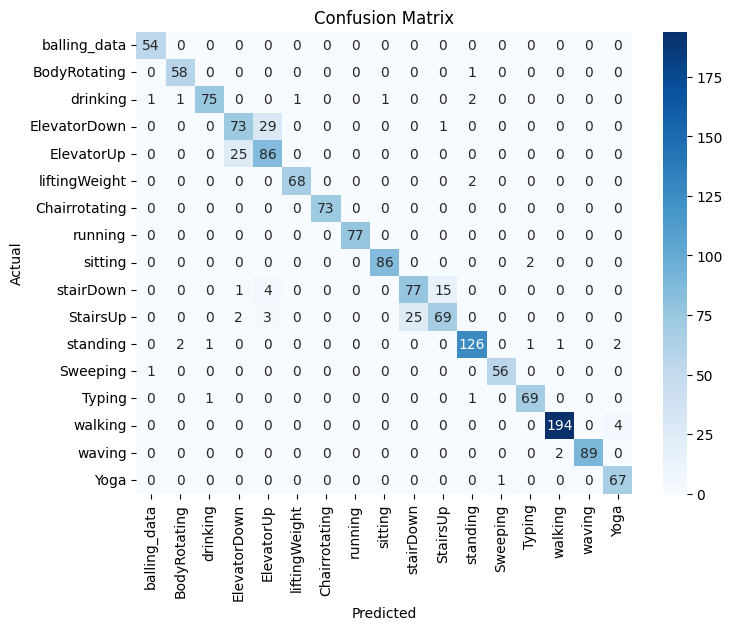

In [6]:
#this is XGBoost
# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Splitting the data
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

# XGBoost Classifier
xgb_model = XGBClassifier(n_estimators=200, learning_rate=0.1, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train_encoded)
y_pred_xgb = xgb_model.predict(X_test)

# Convert the predictions back to the original class names if necessary
y_pred_xgb_labels = label_encoder.inverse_transform(y_pred_xgb)

# Evaluate XGBoost Classifier
accuracy_xgb = accuracy_score(y_test_encoded, y_pred_xgb)
# conf_matrix_xgb = confusion_matrix(y_test_encoded, y_pred_xgb)
print(f"XGBoost Classifier Accuracy: {accuracy_xgb * 100:.2f}%")
print("XGBoost Classifier Confusion Matrix:")
# print(conf_matrix_xgb)
print(classification_report(y_test_encoded, y_pred_xgb))

#### Compute confusion matrix
confusion = confusion_matrix( y_test_encoded, y_pred_xgb)

class_labels = ['balling_data', 'BodyRotating', 'drinking','ElevatorDown','ElevatorUp','liftingWeight','Chairrotating','running', 'sitting','stairDown','StairsUp', 'standing', 'Sweeping','Typing','walking', 'waving','Yoga' ] 
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [7]:
#this is Random Forest classifier

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



# Model Training
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)



# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)



# Model Evaluation
print(f"Random forest Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_test, y_pred))


Random forest Accuracy: 93.33%
              precision    recall  f1-score   support

        ball       1.00      0.98      0.99        64
bodyrotating       0.98      0.98      0.98        49
       drink       0.97      0.96      0.97        81
    liftDown       0.76      0.82      0.79       103
      liftUp       0.80      0.77      0.79       106
      liftwt       0.94      0.99      0.96        69
    rotating       1.00      1.00      1.00        65
     running       0.99      0.99      0.99        80
     sitting       1.00      0.99      0.99        85
   stairDown       0.84      0.74      0.79        89
     stairUp       0.80      0.86      0.83        95
    standing       0.96      0.96      0.96       140
    sweeping       1.00      0.94      0.97        49
      typing       0.97      1.00      0.98        63
     walking       0.99      0.99      0.99       225
      waving       0.99      0.98      0.98        96
        yoga       0.96      0.97      0.97       

In [8]:
#y_test.value_counts()

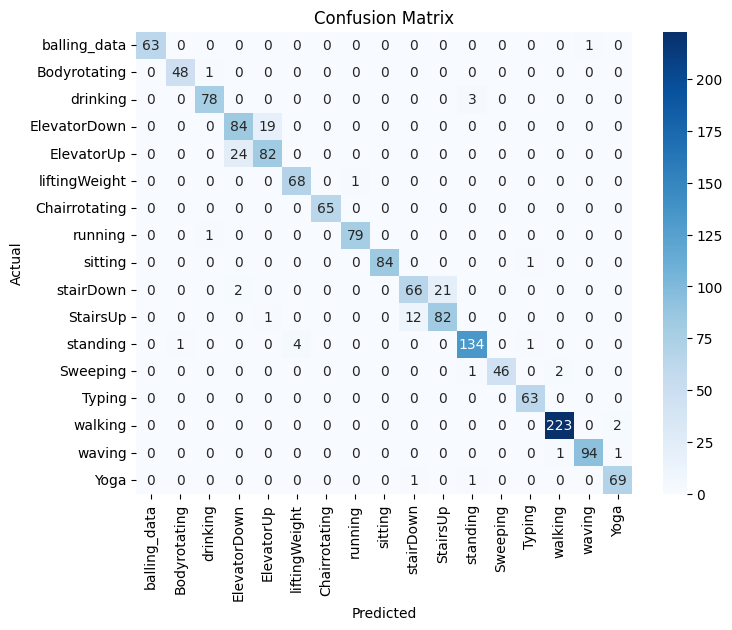

In [9]:
# Compute confusion matrix
confusion = confusion_matrix( y_test, y_pred)

class_labels = ['balling_data','Bodyrotating', 'drinking','ElevatorDown','ElevatorUp','liftingWeight','Chairrotating','running', 'sitting','stairDown','StairsUp', 'standing', 'Sweeping','Typing','walking', 'waving','Yoga' ] 

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [10]:
from joblib import dump
from joblib import load
from collections import Counter


# Save the model to a file
model_filename = 'HARDemo_trained_model.joblib'
dump(rf_model, model_filename)

# Load the model from the file|
rf_model = load(model_filename)


In [17]:
unseen_data = pd.read_csv('Unseen/UnseenSs2.csv') 
smoothed_unseen_data = smooth_data(unseen_data)
# Segment into windows     
unseen_windows = segment_into_windows(unseen_data, points_per_window=58*2)
# Extract features from each window
unseen_window_features = [extract_features(window) for window in unseen_windows]
# Convert to DataFrame
unseen_feature_df = pd.DataFrame(unseen_window_features)


In [19]:
unseen_feature_df

,x_mean,x_std,x_var,x_median,x_skew,x_kurtosis,y_mean,y_std,y_var,y_median,...,cross_corr_xy,cross_corr_xz,cross_corr_yz,x_spectral_centroid,x_spectral_spread,y_spectral_centroid,y_spectral_spread,z_spectral_centroid,z_spectral_spread,signal_intensity
0,1.621616,2.603321,6.777280,1.718466,0.607887,0.365637,0.375242,2.871792,8.247191,0.202088,...,433.122000,640.858070,353.165358,51.636640,50.478116,56.431461,48.558669,53.189802,49.012121,757.425860
1,1.624821,4.047690,16.383798,0.687447,0.616714,-0.553215,-1.237858,4.569624,20.881461,-1.945825,...,1569.724949,1126.186412,835.975004,53.108291,50.964182,53.936376,49.673776,52.428562,52.063331,1106.926377
2,1.308199,3.789482,14.360171,0.172049,0.875795,-0.517753,-0.378532,3.794518,14.398367,-0.245956,...,1177.782842,650.908185,619.373973,53.636895,48.899157,56.089560,52.857835,53.191613,50.008706,882.083793
3,1.411042,4.002458,16.019673,0.273250,0.740893,-0.439979,-0.733274,4.344384,18.873674,-0.664239,...,1310.722493,767.020122,731.953341,53.825089,49.437786,55.079004,50.369186,54.908524,49.371855,985.595274
4,1.145185,3.986639,15.893287,-0.141767,0.820939,-0.431888,-0.939816,3.723679,13.865784,-0.913063,...,1045.262261,748.260305,465.019084,54.097609,51.319378,53.633875,52.499578,52.128907,51.566668,897.254329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,0.457252,0.273185,0.074630,0.462703,0.511575,3.728504,0.888224,0.202058,0.040827,0.895529,...,49.359329,7.624002,10.480861,46.343051,47.349533,34.464492,45.605169,55.045365,47.795322,183.477767
80,0.280050,0.220487,0.048615,0.309719,-0.370533,-0.268463,0.620136,0.214487,0.046005,0.617989,...,23.760332,3.137162,3.888008,47.667648,48.506164,37.446730,48.826237,55.908013,47.058437,124.720368
81,0.188264,0.147106,0.021640,0.181709,-0.322363,0.115308,0.402696,0.081235,0.006599,0.413580,...,9.178510,1.964556,2.287238,48.323450,46.990803,33.221288,45.067110,55.495807,46.069002,83.606758
82,0.121791,0.135304,0.018307,0.126168,-0.439353,0.068278,0.271887,0.082539,0.006813,0.263189,...,4.355607,0.866503,0.990836,51.166420,46.256425,38.975885,46.406810,56.967153,44.865837,61.553540


In [20]:

# Load the saved model
rf_model = load('HARDemo_trained_model.joblib')
# Make predictions
unseen_predictions = rf_model.predict(unseen_feature_df)
# Now 'unseen_predictions' contains the predicted activities for each window
# unseen_predictions
# unseen_feature_df.columns


# Calculate the count of each activity
activity_counts = Counter(unseen_predictions)

# Calculate the total count of all activities
total_count = len(unseen_predictions)

# Calculate the percentage of each activity
activity_percentages = {activity: count / total_count * 100 for activity, count in activity_counts.items()}

# Print the counts and percentages
for activity, count in activity_counts.items():
    percentage = activity_percentages[activity]
    print(f'{activity}: Count={count}, Percentage={percentage:.2f}%')
unseen_predictions

walking: Count=46, Percentage=54.76%
liftwt: Count=1, Percentage=1.19%
standing: Count=34, Percentage=40.48%
yoga: Count=2, Percentage=2.38%
bodyrotating: Count=1, Percentage=1.19%


array(['walking', 'walking', 'walking', 'walking', 'walking', 'walking',
       'walking', 'walking', 'walking', 'walking', 'walking', 'liftwt',
       'standing', 'walking', 'walking', 'walking', 'walking', 'walking',
       'walking', 'walking', 'standing', 'standing', 'standing',
       'standing', 'standing', 'standing', 'walking', 'walking',
       'walking', 'walking', 'walking', 'walking', 'yoga', 'standing',
       'standing', 'standing', 'standing', 'standing', 'standing',
       'standing', 'standing', 'standing', 'standing', 'walking',
       'walking', 'walking', 'walking', 'walking', 'walking', 'standing',
       'standing', 'standing', 'standing', 'standing', 'standing',
       'standing', 'walking', 'walking', 'walking', 'walking', 'walking',
       'walking', 'yoga', 'standing', 'standing', 'standing', 'standing',
       'standing', 'standing', 'walking', 'walking', 'walking', 'walking',
       'walking', 'walking', 'walking', 'walking', 'walking', 'walking',
       'bo

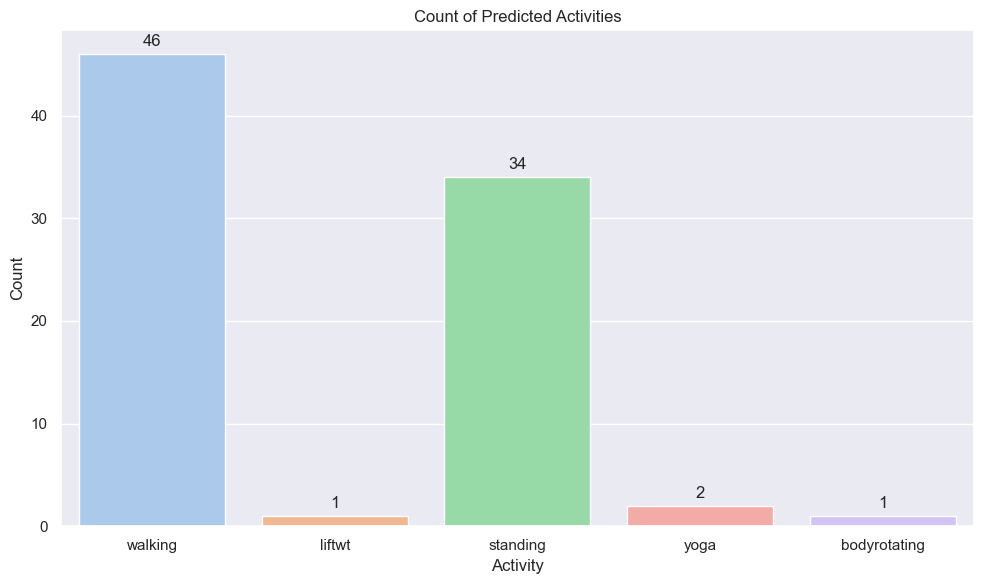

In [21]:


# Suppress specific FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Count the occurrences of each activity in the predictions
activity_counts = Counter(unseen_predictions)

# Set up the seaborn style for better aesthetics
sns.set()

# Create the bar chart
plt.figure(figsize=(10, 6))

# Plot the bars using seaborn; the warning related to `palette` will be suppressed
ax = sns.barplot(x=list(activity_counts.keys()), y=list(activity_counts.values()), palette='pastel')

# Adding the exact count on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points')

# Set the labels and title
plt.xlabel('Activity')
plt.ylabel('Count')
plt.title('Count of Predicted Activities')

# Show the plot
plt.tight_layout()
plt.show()

# Reset warnings to default behavior for the rest of your code
warnings.simplefilter(action='default', category=FutureWarning)